In [ ]:
# Install dependencies
!pip install -U transformers datasets optuna accelerate matplotlib

# Imports
import torch
import time
import numpy as np
import optuna
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from itertools import product
import random
import gc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Load dataset
dataset = load_dataset("imdb")
dataset = dataset["train"].shuffle(seed=42).select(range(5000))  # take a small subset
dataset = dataset.train_test_split(test_size=0.2)

# Tokenize
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_fn(batch):
    return tokenizer(batch['text'], truncation=True, padding="max_length", max_length=256)

dataset = dataset.map(tokenize_fn, batched=True)
dataset.set_format(type="torch", columns=['input_ids', 'attention_mask', 'label'])

# Compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": accuracy_score(labels, preds)}

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# Train function
def train_with_params(params, run_id="run"):
    epochs, batch_size, lr, fp16 = params
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
    training_args = TrainingArguments(
        output_dir=f"./results/{run_id}",
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        learning_rate=lr,
        fp16=fp16,
        logging_dir=f"./logs/{run_id}",
        disable_tqdm=True,
        report_to="none",
        save_strategy="no"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["test"],
        compute_metrics=compute_metrics
    )

    start_time = time.time()
    trainer.train()
    eval_results = trainer.evaluate()
    time_taken = time.time() - start_time

    # GPU memory usage
    memory_mb = torch.cuda.max_memory_allocated() / 1024**2 if torch.cuda.is_available() else 0
    torch.cuda.reset_peak_memory_stats()
    del trainer
    del model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return {
        "params": params,
        "accuracy": eval_results["eval_accuracy"],
        "time": time_taken,
        "memory": memory_mb
    }

In [ ]:
# Grid Search
epochs = [2, 3]
batch_sizes = [8, 16]
lrs = [2e-5, 5e-5]
precisions = [True, False]
grid = list(product(epochs, batch_sizes, lrs, precisions))

grid_results = [train_with_params(params, run_id=f"grid_{i}") for i, params in enumerate(grid)]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.4088, 'grad_norm': 26.635589599609375, 'learning_rate': 1.008e-05, 'epoch': 1.0}
{'eval_loss': 0.29635125398635864, 'eval_accuracy': 0.884, 'eval_runtime': 1.9225, 'eval_samples_per_second': 520.167, 'eval_steps_per_second': 65.021, 'epoch': 1.0}
{'loss': 0.2303, 'grad_norm': 19.078340530395508, 'learning_rate': 8e-08, 'epoch': 2.0}
{'eval_loss': 0.36596381664276123, 'eval_accuracy': 0.885, 'eval_runtime': 1.785, 'eval_samples_per_second': 560.22, 'eval_steps_per_second': 70.028, 'epoch': 2.0}
{'train_runtime': 80.9845, 'train_samples_per_second': 98.784, 'train_steps_per_second': 12.348, 'train_loss': 0.3195637741088867, 'epoch': 2.0}
{'eval_loss': 0.36596381664276123, 'eval_accuracy': 0.885, 'eval_runtime': 1.8027, 'eval_samples_per_second': 554.733, 'eval_steps_per_second': 69.342, 'epoch': 2.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.4025, 'grad_norm': 31.30899429321289, 'learning_rate': 1.008e-05, 'epoch': 1.0}
{'eval_loss': 0.2989048957824707, 'eval_accuracy': 0.886, 'eval_runtime': 1.8646, 'eval_samples_per_second': 536.301, 'eval_steps_per_second': 67.038, 'epoch': 1.0}
{'loss': 0.2194, 'grad_norm': 23.105113983154297, 'learning_rate': 8e-08, 'epoch': 2.0}
{'eval_loss': 0.36511701345443726, 'eval_accuracy': 0.887, 'eval_runtime': 1.8697, 'eval_samples_per_second': 534.851, 'eval_steps_per_second': 66.856, 'epoch': 2.0}
{'train_runtime': 72.0573, 'train_samples_per_second': 111.023, 'train_steps_per_second': 13.878, 'train_loss': 0.31095352172851565, 'epoch': 2.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.36511701345443726, 'eval_accuracy': 0.887, 'eval_runtime': 1.8653, 'eval_samples_per_second': 536.105, 'eval_steps_per_second': 67.013, 'epoch': 2.0}
{'loss': 0.4164, 'grad_norm': 13.756637573242188, 'learning_rate': 2.5200000000000003e-05, 'epoch': 1.0}
{'eval_loss': 0.3308548033237457, 'eval_accuracy': 0.863, 'eval_runtime': 1.8414, 'eval_samples_per_second': 543.053, 'eval_steps_per_second': 67.882, 'epoch': 1.0}
{'loss': 0.186, 'grad_norm': 24.786760330200195, 'learning_rate': 2.0000000000000002e-07, 'epoch': 2.0}
{'eval_loss': 0.49498090147972107, 'eval_accuracy': 0.87, 'eval_runtime': 1.8549, 'eval_samples_per_second': 539.118, 'eval_steps_per_second': 67.39, 'epoch': 2.0}
{'train_runtime': 72.796, 'train_samples_per_second': 109.896, 'train_steps_per_second': 13.737, 'train_loss': 0.30118526458740236, 'epoch': 2.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.49498090147972107, 'eval_accuracy': 0.87, 'eval_runtime': 1.8553, 'eval_samples_per_second': 539.008, 'eval_steps_per_second': 67.376, 'epoch': 2.0}
{'loss': 0.4164, 'grad_norm': 13.756637573242188, 'learning_rate': 2.5200000000000003e-05, 'epoch': 1.0}
{'eval_loss': 0.3308548033237457, 'eval_accuracy': 0.863, 'eval_runtime': 1.8605, 'eval_samples_per_second': 537.485, 'eval_steps_per_second': 67.186, 'epoch': 1.0}
{'loss': 0.186, 'grad_norm': 24.786760330200195, 'learning_rate': 2.0000000000000002e-07, 'epoch': 2.0}
{'eval_loss': 0.49498090147972107, 'eval_accuracy': 0.87, 'eval_runtime': 1.8675, 'eval_samples_per_second': 535.472, 'eval_steps_per_second': 66.934, 'epoch': 2.0}
{'train_runtime': 73.2784, 'train_samples_per_second': 109.173, 'train_steps_per_second': 13.647, 'train_loss': 0.30118526458740236, 'epoch': 2.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.49498090147972107, 'eval_accuracy': 0.87, 'eval_runtime': 1.8634, 'eval_samples_per_second': 536.642, 'eval_steps_per_second': 67.08, 'epoch': 2.0}
{'eval_loss': 0.3048163950443268, 'eval_accuracy': 0.875, 'eval_runtime': 1.6868, 'eval_samples_per_second': 592.85, 'eval_steps_per_second': 37.35, 'epoch': 1.0}
{'loss': 0.3106, 'grad_norm': 9.364835739135742, 'learning_rate': 1.2000000000000002e-07, 'epoch': 2.0}
{'eval_loss': 0.30111655592918396, 'eval_accuracy': 0.885, 'eval_runtime': 1.6544, 'eval_samples_per_second': 604.433, 'eval_steps_per_second': 38.079, 'epoch': 2.0}
{'train_runtime': 55.8791, 'train_samples_per_second': 143.166, 'train_steps_per_second': 8.948, 'train_loss': 0.3106496276855469, 'epoch': 2.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.30111655592918396, 'eval_accuracy': 0.885, 'eval_runtime': 1.6603, 'eval_samples_per_second': 602.303, 'eval_steps_per_second': 37.945, 'epoch': 2.0}
{'eval_loss': 0.3048163950443268, 'eval_accuracy': 0.875, 'eval_runtime': 1.6868, 'eval_samples_per_second': 592.827, 'eval_steps_per_second': 37.348, 'epoch': 1.0}
{'loss': 0.3106, 'grad_norm': 9.364835739135742, 'learning_rate': 1.2000000000000002e-07, 'epoch': 2.0}
{'eval_loss': 0.30111655592918396, 'eval_accuracy': 0.885, 'eval_runtime': 1.6835, 'eval_samples_per_second': 594.002, 'eval_steps_per_second': 37.422, 'epoch': 2.0}
{'train_runtime': 55.5159, 'train_samples_per_second': 144.103, 'train_steps_per_second': 9.006, 'train_loss': 0.3106496276855469, 'epoch': 2.0}
{'eval_loss': 0.30111655592918396, 'eval_accuracy': 0.885, 'eval_runtime': 1.6705, 'eval_samples_per_second': 598.611, 'eval_steps_per_second': 37.712, 'epoch': 2.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.29999345541000366, 'eval_accuracy': 0.88, 'eval_runtime': 1.6914, 'eval_samples_per_second': 591.22, 'eval_steps_per_second': 37.247, 'epoch': 1.0}
{'loss': 0.2792, 'grad_norm': 4.099737644195557, 'learning_rate': 3.0000000000000004e-07, 'epoch': 2.0}
{'eval_loss': 0.3315337002277374, 'eval_accuracy': 0.892, 'eval_runtime': 1.6733, 'eval_samples_per_second': 597.621, 'eval_steps_per_second': 37.65, 'epoch': 2.0}
{'train_runtime': 55.5591, 'train_samples_per_second': 143.991, 'train_steps_per_second': 8.999, 'train_loss': 0.27917941284179687, 'epoch': 2.0}
{'eval_loss': 0.3315337002277374, 'eval_accuracy': 0.892, 'eval_runtime': 1.6877, 'eval_samples_per_second': 592.521, 'eval_steps_per_second': 37.329, 'epoch': 2.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.29999345541000366, 'eval_accuracy': 0.88, 'eval_runtime': 1.6872, 'eval_samples_per_second': 592.698, 'eval_steps_per_second': 37.34, 'epoch': 1.0}
{'loss': 0.2792, 'grad_norm': 4.099737644195557, 'learning_rate': 3.0000000000000004e-07, 'epoch': 2.0}
{'eval_loss': 0.3315337002277374, 'eval_accuracy': 0.892, 'eval_runtime': 1.671, 'eval_samples_per_second': 598.43, 'eval_steps_per_second': 37.701, 'epoch': 2.0}
{'train_runtime': 55.597, 'train_samples_per_second': 143.893, 'train_steps_per_second': 8.993, 'train_loss': 0.27917941284179687, 'epoch': 2.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.3315337002277374, 'eval_accuracy': 0.892, 'eval_runtime': 1.6669, 'eval_samples_per_second': 599.921, 'eval_steps_per_second': 37.795, 'epoch': 2.0}
{'loss': 0.4059, 'grad_norm': 22.250362396240234, 'learning_rate': 1.3386666666666668e-05, 'epoch': 1.0}
{'eval_loss': 0.27730634808540344, 'eval_accuracy': 0.892, 'eval_runtime': 1.8771, 'eval_samples_per_second': 532.742, 'eval_steps_per_second': 66.593, 'epoch': 1.0}
{'loss': 0.2257, 'grad_norm': 34.23664093017578, 'learning_rate': 6.720000000000001e-06, 'epoch': 2.0}
{'eval_loss': 0.41212350130081177, 'eval_accuracy': 0.881, 'eval_runtime': 1.8873, 'eval_samples_per_second': 529.848, 'eval_steps_per_second': 66.231, 'epoch': 2.0}
{'loss': 0.1229, 'grad_norm': 0.049637869000434875, 'learning_rate': 6.666666666666668e-08, 'epoch': 3.0}
{'eval_loss': 0.4450581669807434, 'eval_accuracy': 0.888, 'eval_runtime': 1.906, 'eval_samples_per_second': 524.654, 'eval_steps_per_second': 65.582, 'epoch': 3.0}
{'train_runtime': 109.622

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4450581669807434, 'eval_accuracy': 0.888, 'eval_runtime': 1.934, 'eval_samples_per_second': 517.059, 'eval_steps_per_second': 64.632, 'epoch': 3.0}
{'loss': 0.4072, 'grad_norm': 20.56822967529297, 'learning_rate': 1.3386666666666668e-05, 'epoch': 1.0}
{'eval_loss': 0.287698894739151, 'eval_accuracy': 0.89, 'eval_runtime': 1.8799, 'eval_samples_per_second': 531.933, 'eval_steps_per_second': 66.492, 'epoch': 1.0}
{'loss': 0.2294, 'grad_norm': 7.417285919189453, 'learning_rate': 6.720000000000001e-06, 'epoch': 2.0}
{'eval_loss': 0.4430581033229828, 'eval_accuracy': 0.878, 'eval_runtime': 1.8883, 'eval_samples_per_second': 529.576, 'eval_steps_per_second': 66.197, 'epoch': 2.0}
{'loss': 0.1218, 'grad_norm': 0.05732160806655884, 'learning_rate': 5.3333333333333334e-08, 'epoch': 3.0}
{'eval_loss': 0.49184900522232056, 'eval_accuracy': 0.882, 'eval_runtime': 1.8861, 'eval_samples_per_second': 530.202, 'eval_steps_per_second': 66.275, 'epoch': 3.0}
{'train_runtime': 109.5194, '

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.49184900522232056, 'eval_accuracy': 0.882, 'eval_runtime': 1.8969, 'eval_samples_per_second': 527.166, 'eval_steps_per_second': 65.896, 'epoch': 3.0}
{'loss': 0.413, 'grad_norm': 18.909168243408203, 'learning_rate': 3.343333333333333e-05, 'epoch': 1.0}
{'eval_loss': 0.3114530146121979, 'eval_accuracy': 0.88, 'eval_runtime': 1.8781, 'eval_samples_per_second': 532.463, 'eval_steps_per_second': 66.558, 'epoch': 1.0}
{'loss': 0.205, 'grad_norm': 5.392298698425293, 'learning_rate': 1.6800000000000002e-05, 'epoch': 2.0}
{'eval_loss': 0.5253783464431763, 'eval_accuracy': 0.877, 'eval_runtime': 1.8899, 'eval_samples_per_second': 529.122, 'eval_steps_per_second': 66.14, 'epoch': 2.0}
{'loss': 0.0666, 'grad_norm': 0.027777547016739845, 'learning_rate': 1.3333333333333334e-07, 'epoch': 3.0}
{'eval_loss': 0.5436444878578186, 'eval_accuracy': 0.89, 'eval_runtime': 1.887, 'eval_samples_per_second': 529.943, 'eval_steps_per_second': 66.243, 'epoch': 3.0}
{'train_runtime': 109.5351, 't

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.413, 'grad_norm': 18.909168243408203, 'learning_rate': 3.343333333333333e-05, 'epoch': 1.0}
{'eval_loss': 0.3114530146121979, 'eval_accuracy': 0.88, 'eval_runtime': 1.9189, 'eval_samples_per_second': 521.134, 'eval_steps_per_second': 65.142, 'epoch': 1.0}
{'loss': 0.205, 'grad_norm': 5.392298698425293, 'learning_rate': 1.6800000000000002e-05, 'epoch': 2.0}
{'eval_loss': 0.5253783464431763, 'eval_accuracy': 0.877, 'eval_runtime': 1.9026, 'eval_samples_per_second': 525.6, 'eval_steps_per_second': 65.7, 'epoch': 2.0}
{'loss': 0.0666, 'grad_norm': 0.027777547016739845, 'learning_rate': 1.3333333333333334e-07, 'epoch': 3.0}
{'eval_loss': 0.5436444878578186, 'eval_accuracy': 0.89, 'eval_runtime': 1.878, 'eval_samples_per_second': 532.487, 'eval_steps_per_second': 66.561, 'epoch': 3.0}
{'train_runtime': 109.4749, 'train_samples_per_second': 109.614, 'train_steps_per_second': 13.702, 'train_loss': 0.22821561431884765, 'epoch': 3.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.5436444878578186, 'eval_accuracy': 0.89, 'eval_runtime': 1.8929, 'eval_samples_per_second': 528.287, 'eval_steps_per_second': 66.036, 'epoch': 3.0}
{'eval_loss': 0.3161035478115082, 'eval_accuracy': 0.869, 'eval_runtime': 1.7003, 'eval_samples_per_second': 588.141, 'eval_steps_per_second': 37.053, 'epoch': 1.0}
{'loss': 0.3118, 'grad_norm': 12.954025268554688, 'learning_rate': 6.746666666666667e-06, 'epoch': 2.0}
{'eval_loss': 0.33530470728874207, 'eval_accuracy': 0.893, 'eval_runtime': 1.6995, 'eval_samples_per_second': 588.411, 'eval_steps_per_second': 37.07, 'epoch': 2.0}
{'eval_loss': 0.3897440731525421, 'eval_accuracy': 0.885, 'eval_runtime': 1.7001, 'eval_samples_per_second': 588.189, 'eval_steps_per_second': 37.056, 'epoch': 3.0}
{'train_runtime': 83.5589, 'train_samples_per_second': 143.611, 'train_steps_per_second': 8.976, 'train_loss': 0.2539941711425781, 'epoch': 3.0}
{'eval_loss': 0.3897440731525421, 'eval_accuracy': 0.885, 'eval_runtime': 1.6825, 'eval_samp

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.3161035478115082, 'eval_accuracy': 0.869, 'eval_runtime': 1.7031, 'eval_samples_per_second': 587.165, 'eval_steps_per_second': 36.991, 'epoch': 1.0}
{'loss': 0.3118, 'grad_norm': 12.954025268554688, 'learning_rate': 6.746666666666667e-06, 'epoch': 2.0}
{'eval_loss': 0.33530470728874207, 'eval_accuracy': 0.893, 'eval_runtime': 1.6752, 'eval_samples_per_second': 596.948, 'eval_steps_per_second': 37.608, 'epoch': 2.0}
{'eval_loss': 0.3897440731525421, 'eval_accuracy': 0.885, 'eval_runtime': 1.701, 'eval_samples_per_second': 587.88, 'eval_steps_per_second': 37.036, 'epoch': 3.0}
{'train_runtime': 83.6398, 'train_samples_per_second': 143.472, 'train_steps_per_second': 8.967, 'train_loss': 0.2539941711425781, 'epoch': 3.0}
{'eval_loss': 0.3897440731525421, 'eval_accuracy': 0.885, 'eval_runtime': 1.6733, 'eval_samples_per_second': 597.605, 'eval_steps_per_second': 37.649, 'epoch': 3.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.3018827438354492, 'eval_accuracy': 0.875, 'eval_runtime': 1.6846, 'eval_samples_per_second': 593.628, 'eval_steps_per_second': 37.399, 'epoch': 1.0}
{'loss': 0.2938, 'grad_norm': 12.217448234558105, 'learning_rate': 1.6866666666666666e-05, 'epoch': 2.0}
{'eval_loss': 0.34028640389442444, 'eval_accuracy': 0.884, 'eval_runtime': 1.6724, 'eval_samples_per_second': 597.933, 'eval_steps_per_second': 37.67, 'epoch': 2.0}
{'eval_loss': 0.45089998841285706, 'eval_accuracy': 0.884, 'eval_runtime': 1.7018, 'eval_samples_per_second': 587.615, 'eval_steps_per_second': 37.02, 'epoch': 3.0}
{'train_runtime': 83.4926, 'train_samples_per_second': 143.725, 'train_steps_per_second': 8.983, 'train_loss': 0.2204302927652995, 'epoch': 3.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.45089998841285706, 'eval_accuracy': 0.884, 'eval_runtime': 1.6889, 'eval_samples_per_second': 592.104, 'eval_steps_per_second': 37.303, 'epoch': 3.0}
{'eval_loss': 0.3018827438354492, 'eval_accuracy': 0.875, 'eval_runtime': 1.6935, 'eval_samples_per_second': 590.504, 'eval_steps_per_second': 37.202, 'epoch': 1.0}
{'loss': 0.2938, 'grad_norm': 12.217448234558105, 'learning_rate': 1.6866666666666666e-05, 'epoch': 2.0}
{'eval_loss': 0.34028640389442444, 'eval_accuracy': 0.884, 'eval_runtime': 1.6686, 'eval_samples_per_second': 599.306, 'eval_steps_per_second': 37.756, 'epoch': 2.0}
{'eval_loss': 0.45089998841285706, 'eval_accuracy': 0.884, 'eval_runtime': 1.6994, 'eval_samples_per_second': 588.452, 'eval_steps_per_second': 37.072, 'epoch': 3.0}
{'train_runtime': 83.4057, 'train_samples_per_second': 143.875, 'train_steps_per_second': 8.992, 'train_loss': 0.2204302927652995, 'epoch': 3.0}
{'eval_loss': 0.45089998841285706, 'eval_accuracy': 0.884, 'eval_runtime': 1.6695, 'eva

In [ ]:
# Random Search
random_trials = 10
search_space = {
    "epochs": [2, 3],
    "batch_size": [8, 16],
    "lr": [2e-5, 5e-5, 1e-5],
    "fp16": [True, False]
}
random_results = []
best_random_acc = 0
no_improve_counter = 0

for i in range(random_trials):
    params = (
        random.choice(search_space["epochs"]),
        random.choice(search_space["batch_size"]),
        random.choice(search_space["lr"]),
        random.choice(search_space["fp16"])
    )
    result = train_with_params(params, run_id=f"random_{i}")
    random_results.append(result)

    if result["accuracy"] > best_random_acc:
        best_random_acc = result["accuracy"]
        no_improve_counter = 0
    else:
        no_improve_counter += 1

    if no_improve_counter >= 3:
        break  # early stop

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.4225, 'grad_norm': 21.682043075561523, 'learning_rate': 5.04e-06, 'epoch': 1.0}
{'eval_loss': 0.3360164761543274, 'eval_accuracy': 0.866, 'eval_runtime': 1.8716, 'eval_samples_per_second': 534.303, 'eval_steps_per_second': 66.788, 'epoch': 1.0}
{'loss': 0.2645, 'grad_norm': 16.127729415893555, 'learning_rate': 5.0000000000000004e-08, 'epoch': 2.0}
{'eval_loss': 0.33103635907173157, 'eval_accuracy': 0.89, 'eval_runtime': 1.8736, 'eval_samples_per_second': 533.738, 'eval_steps_per_second': 66.717, 'epoch': 2.0}
{'train_runtime': 72.9733, 'train_samples_per_second': 109.629, 'train_steps_per_second': 13.704, 'train_loss': 0.34351182556152343, 'epoch': 2.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.33103635907173157, 'eval_accuracy': 0.89, 'eval_runtime': 1.882, 'eval_samples_per_second': 531.338, 'eval_steps_per_second': 66.417, 'epoch': 2.0}
{'loss': 0.4218, 'grad_norm': 26.05292510986328, 'learning_rate': 5.03e-06, 'epoch': 1.0}
{'eval_loss': 0.3166032135486603, 'eval_accuracy': 0.884, 'eval_runtime': 1.8797, 'eval_samples_per_second': 531.998, 'eval_steps_per_second': 66.5, 'epoch': 1.0}
{'loss': 0.263, 'grad_norm': 11.971961975097656, 'learning_rate': 5.0000000000000004e-08, 'epoch': 2.0}
{'eval_loss': 0.3324583172798157, 'eval_accuracy': 0.887, 'eval_runtime': 1.8782, 'eval_samples_per_second': 532.419, 'eval_steps_per_second': 66.552, 'epoch': 2.0}
{'train_runtime': 72.916, 'train_samples_per_second': 109.715, 'train_steps_per_second': 13.714, 'train_loss': 0.34243006896972655, 'epoch': 2.0}
{'eval_loss': 0.3324583172798157, 'eval_accuracy': 0.887, 'eval_runtime': 1.9466, 'eval_samples_per_second': 513.717, 'eval_steps_per_second': 64.215, 'epoch': 2.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.4218, 'grad_norm': 26.05292510986328, 'learning_rate': 5.03e-06, 'epoch': 1.0}
{'eval_loss': 0.3166032135486603, 'eval_accuracy': 0.884, 'eval_runtime': 1.8955, 'eval_samples_per_second': 527.572, 'eval_steps_per_second': 65.947, 'epoch': 1.0}
{'loss': 0.263, 'grad_norm': 11.971961975097656, 'learning_rate': 5.0000000000000004e-08, 'epoch': 2.0}
{'eval_loss': 0.3324583172798157, 'eval_accuracy': 0.887, 'eval_runtime': 1.8752, 'eval_samples_per_second': 533.284, 'eval_steps_per_second': 66.66, 'epoch': 2.0}
{'train_runtime': 72.9607, 'train_samples_per_second': 109.648, 'train_steps_per_second': 13.706, 'train_loss': 0.34243006896972655, 'epoch': 2.0}
{'eval_loss': 0.3324583172798157, 'eval_accuracy': 0.887, 'eval_runtime': 1.879, 'eval_samples_per_second': 532.196, 'eval_steps_per_second': 66.525, 'epoch': 2.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.4218, 'grad_norm': 26.05292510986328, 'learning_rate': 5.03e-06, 'epoch': 1.0}
{'eval_loss': 0.3166032135486603, 'eval_accuracy': 0.884, 'eval_runtime': 1.8785, 'eval_samples_per_second': 532.346, 'eval_steps_per_second': 66.543, 'epoch': 1.0}
{'loss': 0.263, 'grad_norm': 11.971961975097656, 'learning_rate': 5.0000000000000004e-08, 'epoch': 2.0}
{'eval_loss': 0.3324583172798157, 'eval_accuracy': 0.887, 'eval_runtime': 1.8828, 'eval_samples_per_second': 531.118, 'eval_steps_per_second': 66.39, 'epoch': 2.0}
{'train_runtime': 72.9703, 'train_samples_per_second': 109.634, 'train_steps_per_second': 13.704, 'train_loss': 0.34243006896972655, 'epoch': 2.0}
{'eval_loss': 0.3324583172798157, 'eval_accuracy': 0.887, 'eval_runtime': 1.8833, 'eval_samples_per_second': 530.983, 'eval_steps_per_second': 66.373, 'epoch': 2.0}


In [ ]:
# Optuna Search
def objective(trial):
    epochs = trial.suggest_int("epochs", 2, 4)
    batch_size = trial.suggest_categorical("batch_size", [8, 16])
    lr = trial.suggest_float("lr", 1e-5, 5e-4, log=True)
    fp16 = trial.suggest_categorical("fp16", [True, False])
    result = train_with_params((epochs, batch_size, lr, fp16), run_id=f"optuna_{trial.number}")
    trial.set_user_attr("time", result["time"])
    trial.set_user_attr("memory", result["memory"])
    return result["accuracy"]

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

optuna_results = [{
    "params": (
        t.params["epochs"],
        t.params["batch_size"],
        t.params["lr"],
        t.params["fp16"]
    ),
    "accuracy": t.value,
    "memory": t.user_attrs["memory"],
    "time": t.user_attrs["time"]
} for t in study.trials]

[I 2025-04-24 07:53:42,577] A new study created in memory with name: no-name-0ab006e1-5434-4be0-b107-826aa6610d2f
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.294685959815979, 'eval_accuracy': 0.876, 'eval_runtime': 1.6922, 'eval_samples_per_second': 590.95, 'eval_steps_per_second': 37.23, 'epoch': 1.0}
{'loss': 0.3039, 'grad_norm': 9.730597496032715, 'learning_rate': 1.2217883903148364e-05, 'epoch': 2.0}
{'eval_loss': 0.3326031565666199, 'eval_accuracy': 0.888, 'eval_runtime': 1.6845, 'eval_samples_per_second': 593.634, 'eval_steps_per_second': 37.399, 'epoch': 2.0}
{'eval_loss': 0.4310437738895416, 'eval_accuracy': 0.878, 'eval_runtime': 1.7016, 'eval_samples_per_second': 587.672, 'eval_steps_per_second': 37.023, 'epoch': 3.0}
{'loss': 0.0827, 'grad_norm': 0.45217376947402954, 'learning_rate': 7.2870082921362e-08, 'epoch': 4.0}
{'eval_loss': 0.4813239276409149, 'eval_accuracy': 0.877, 'eval_runtime': 1.6762, 'eval_samples_per_second': 596.593, 'eval_steps_per_second': 37.585, 'epoch': 4.0}
{'train_runtime': 111.3126, 'train_samples_per_second': 143.739, 'train_steps_per_second': 8.984, 'train_loss': 0.1933101348876953, 'epo

[I 2025-04-24 07:55:36,603] Trial 0 finished with value: 0.877 and parameters: {'epochs': 4, 'batch_size': 16, 'lr': 2.4290027640454002e-05, 'fp16': True}. Best is trial 0 with value: 0.877.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4813239276409149, 'eval_accuracy': 0.877, 'eval_runtime': 1.6842, 'eval_samples_per_second': 593.767, 'eval_steps_per_second': 37.407, 'epoch': 4.0}
{'loss': 0.3963, 'grad_norm': 19.155622482299805, 'learning_rate': 1.5687951183112903e-05, 'epoch': 1.0}
{'eval_loss': 0.3010430335998535, 'eval_accuracy': 0.883, 'eval_runtime': 1.8841, 'eval_samples_per_second': 530.749, 'eval_steps_per_second': 66.344, 'epoch': 1.0}
{'loss': 0.2351, 'grad_norm': 30.648897171020508, 'learning_rate': 1.0472541880216326e-05, 'epoch': 2.0}
{'eval_loss': 0.42152726650238037, 'eval_accuracy': 0.885, 'eval_runtime': 1.8791, 'eval_samples_per_second': 532.166, 'eval_steps_per_second': 66.521, 'epoch': 2.0}
{'loss': 0.1191, 'grad_norm': 0.0475393682718277, 'learning_rate': 5.267563395925542e-06, 'epoch': 3.0}
{'eval_loss': 0.47601819038391113, 'eval_accuracy': 0.887, 'eval_runtime': 1.8797, 'eval_samples_per_second': 532.013, 'eval_steps_per_second': 66.502, 'epoch': 3.0}
{'loss': 0.0581, 'grad_n

[I 2025-04-24 07:58:05,305] Trial 1 finished with value: 0.88 and parameters: {'epochs': 4, 'batch_size': 8, 'lr': 2.0861637211586308e-05, 'fp16': True}. Best is trial 1 with value: 0.88.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.5348320603370667, 'eval_accuracy': 0.88, 'eval_runtime': 1.8821, 'eval_samples_per_second': 531.325, 'eval_steps_per_second': 66.416, 'epoch': 4.0}
{'eval_loss': 0.29984691739082336, 'eval_accuracy': 0.881, 'eval_runtime': 1.6974, 'eval_samples_per_second': 589.128, 'eval_steps_per_second': 37.115, 'epoch': 1.0}
{'loss': 0.3247, 'grad_norm': 7.6456098556518555, 'learning_rate': 9.257736062223173e-07, 'epoch': 2.0}
{'eval_loss': 0.35440269112586975, 'eval_accuracy': 0.88, 'eval_runtime': 1.6866, 'eval_samples_per_second': 592.893, 'eval_steps_per_second': 37.352, 'epoch': 2.0}
{'train_runtime': 55.6313, 'train_samples_per_second': 143.804, 'train_steps_per_second': 8.988, 'train_loss': 0.3247460021972656, 'epoch': 2.0}


[I 2025-04-24 07:59:03,626] Trial 2 finished with value: 0.88 and parameters: {'epochs': 2, 'batch_size': 16, 'lr': 0.00015429560103705288, 'fp16': True}. Best is trial 1 with value: 0.88.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.35440269112586975, 'eval_accuracy': 0.88, 'eval_runtime': 1.6832, 'eval_samples_per_second': 594.123, 'eval_steps_per_second': 37.43, 'epoch': 2.0}
{'eval_loss': 0.2943337559700012, 'eval_accuracy': 0.885, 'eval_runtime': 1.7111, 'eval_samples_per_second': 584.426, 'eval_steps_per_second': 36.819, 'epoch': 1.0}
{'loss': 0.3024, 'grad_norm': 10.718008041381836, 'learning_rate': 1.3338096158681165e-07, 'epoch': 2.0}
{'eval_loss': 0.30189624428749084, 'eval_accuracy': 0.884, 'eval_runtime': 1.6763, 'eval_samples_per_second': 596.551, 'eval_steps_per_second': 37.583, 'epoch': 2.0}
{'train_runtime': 55.7231, 'train_samples_per_second': 143.567, 'train_steps_per_second': 8.973, 'train_loss': 0.30243362426757814, 'epoch': 2.0}
{'eval_loss': 0.30189624428749084, 'eval_accuracy': 0.884, 'eval_runtime': 1.6717, 'eval_samples_per_second': 598.207, 'eval_steps_per_second': 37.687, 'epoch': 2.0}


[I 2025-04-24 08:00:02,037] Trial 3 finished with value: 0.884 and parameters: {'epochs': 2, 'batch_size': 16, 'lr': 2.223016026446861e-05, 'fp16': False}. Best is trial 3 with value: 0.884.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.41207075119018555, 'eval_accuracy': 0.826, 'eval_runtime': 1.6986, 'eval_samples_per_second': 588.737, 'eval_steps_per_second': 37.09, 'epoch': 1.0}
{'loss': 0.4265, 'grad_norm': 7.606381416320801, 'learning_rate': 5.926833169306637e-05, 'epoch': 2.0}
{'eval_loss': 0.4005858302116394, 'eval_accuracy': 0.859, 'eval_runtime': 1.6723, 'eval_samples_per_second': 597.972, 'eval_steps_per_second': 37.672, 'epoch': 2.0}
{'eval_loss': 0.4679083824157715, 'eval_accuracy': 0.851, 'eval_runtime': 1.692, 'eval_samples_per_second': 591.012, 'eval_steps_per_second': 37.234, 'epoch': 3.0}
{'train_runtime': 83.2532, 'train_samples_per_second': 144.139, 'train_steps_per_second': 9.009, 'train_loss': 0.3418549346923828, 'epoch': 3.0}


[I 2025-04-24 08:01:28,232] Trial 4 finished with value: 0.851 and parameters: {'epochs': 3, 'batch_size': 16, 'lr': 0.00017500491641653454, 'fp16': True}. Best is trial 3 with value: 0.884.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.4679083824157715, 'eval_accuracy': 0.851, 'eval_runtime': 1.6643, 'eval_samples_per_second': 600.85, 'eval_steps_per_second': 37.854, 'epoch': 3.0}
{'eval_loss': 0.31040674448013306, 'eval_accuracy': 0.872, 'eval_runtime': 1.69, 'eval_samples_per_second': 591.699, 'eval_steps_per_second': 37.277, 'epoch': 1.0}
{'loss': 0.2918, 'grad_norm': 7.038137912750244, 'learning_rate': 2.761077116894195e-07, 'epoch': 2.0}
{'eval_loss': 0.3437238037586212, 'eval_accuracy': 0.879, 'eval_runtime': 1.6913, 'eval_samples_per_second': 591.251, 'eval_steps_per_second': 37.249, 'epoch': 2.0}
{'train_runtime': 55.6242, 'train_samples_per_second': 143.822, 'train_steps_per_second': 8.989, 'train_loss': 0.2918260498046875, 'epoch': 2.0}


[I 2025-04-24 08:02:26,560] Trial 5 finished with value: 0.879 and parameters: {'epochs': 2, 'batch_size': 16, 'lr': 4.6017951948236584e-05, 'fp16': True}. Best is trial 3 with value: 0.884.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.3437238037586212, 'eval_accuracy': 0.879, 'eval_runtime': 1.6788, 'eval_samples_per_second': 595.657, 'eval_steps_per_second': 37.526, 'epoch': 2.0}
{'loss': 0.5868, 'grad_norm': 11.398950576782227, 'learning_rate': 8.110774893602922e-05, 'epoch': 1.0}
{'eval_loss': 0.5436577200889587, 'eval_accuracy': 0.787, 'eval_runtime': 1.8605, 'eval_samples_per_second': 537.492, 'eval_steps_per_second': 67.186, 'epoch': 1.0}
{'loss': 0.4033, 'grad_norm': 34.49674606323242, 'learning_rate': 8.030470191686062e-07, 'epoch': 2.0}
{'eval_loss': 0.45726466178894043, 'eval_accuracy': 0.823, 'eval_runtime': 1.8473, 'eval_samples_per_second': 541.316, 'eval_steps_per_second': 67.664, 'epoch': 2.0}
{'train_runtime': 72.6953, 'train_samples_per_second': 110.048, 'train_steps_per_second': 13.756, 'train_loss': 0.4950635681152344, 'epoch': 2.0}
{'eval_loss': 0.45726466178894043, 'eval_accuracy': 0.823, 'eval_runtime': 1.8947, 'eval_samples_per_second': 527.778, 'eval_steps_per_second': 65.972,

[I 2025-04-24 08:03:42,265] Trial 6 finished with value: 0.823 and parameters: {'epochs': 2, 'batch_size': 8, 'lr': 0.00016060940383372124, 'fp16': True}. Best is trial 3 with value: 0.884.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.3155044913291931, 'eval_accuracy': 0.87, 'eval_runtime': 1.6916, 'eval_samples_per_second': 591.151, 'eval_steps_per_second': 37.243, 'epoch': 1.0}
{'loss': 0.3475, 'grad_norm': 7.270343780517578, 'learning_rate': 5.520088032370909e-06, 'epoch': 2.0}
{'eval_loss': 0.29422807693481445, 'eval_accuracy': 0.89, 'eval_runtime': 1.6709, 'eval_samples_per_second': 598.484, 'eval_steps_per_second': 37.705, 'epoch': 2.0}
{'eval_loss': 0.32669031620025635, 'eval_accuracy': 0.884, 'eval_runtime': 1.7027, 'eval_samples_per_second': 587.307, 'eval_steps_per_second': 37.0, 'epoch': 3.0}
{'loss': 0.1623, 'grad_norm': 1.0010323524475098, 'learning_rate': 3.2922990252709196e-08, 'epoch': 4.0}
{'eval_loss': 0.34042662382125854, 'eval_accuracy': 0.89, 'eval_runtime': 1.6792, 'eval_samples_per_second': 595.511, 'eval_steps_per_second': 37.517, 'epoch': 4.0}
{'train_runtime': 111.316, 'train_samples_per_second': 143.735, 'train_steps_per_second': 8.983, 'train_loss': 0.2548826217651367, 'ep

[I 2025-04-24 08:05:36,267] Trial 7 finished with value: 0.89 and parameters: {'epochs': 4, 'batch_size': 16, 'lr': 1.0974330084236398e-05, 'fp16': True}. Best is trial 7 with value: 0.89.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.34042662382125854, 'eval_accuracy': 0.89, 'eval_runtime': 1.6659, 'eval_samples_per_second': 600.262, 'eval_steps_per_second': 37.817, 'epoch': 4.0}
{'eval_loss': 0.693188488483429, 'eval_accuracy': 0.499, 'eval_runtime': 1.6376, 'eval_samples_per_second': 610.65, 'eval_steps_per_second': 38.471, 'epoch': 1.0}
{'loss': 0.6985, 'grad_norm': 0.21959277987480164, 'learning_rate': 0.0001576121766789632, 'epoch': 2.0}
{'eval_loss': 0.6936596632003784, 'eval_accuracy': 0.499, 'eval_runtime': 1.6074, 'eval_samples_per_second': 622.111, 'eval_steps_per_second': 39.193, 'epoch': 2.0}
{'eval_loss': 0.6930942535400391, 'eval_accuracy': 0.501, 'eval_runtime': 1.6247, 'eval_samples_per_second': 615.493, 'eval_steps_per_second': 38.776, 'epoch': 3.0}
{'train_runtime': 82.5215, 'train_samples_per_second': 145.417, 'train_steps_per_second': 9.089, 'train_loss': 0.6971128743489583, 'epoch': 3.0}


[I 2025-04-24 08:07:01,434] Trial 8 finished with value: 0.501 and parameters: {'epochs': 3, 'batch_size': 16, 'lr': 0.00047095271916024856, 'fp16': False}. Best is trial 7 with value: 0.89.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.6930942535400391, 'eval_accuracy': 0.501, 'eval_runtime': 1.6111, 'eval_samples_per_second': 620.709, 'eval_steps_per_second': 39.105, 'epoch': 3.0}
{'eval_loss': 0.29520171880722046, 'eval_accuracy': 0.881, 'eval_runtime': 1.7001, 'eval_samples_per_second': 588.215, 'eval_steps_per_second': 37.058, 'epoch': 1.0}
{'loss': 0.2943, 'grad_norm': 10.6569242477417, 'learning_rate': 1.2306156975116488e-05, 'epoch': 2.0}
{'eval_loss': 0.35745054483413696, 'eval_accuracy': 0.879, 'eval_runtime': 1.6646, 'eval_samples_per_second': 600.742, 'eval_steps_per_second': 37.847, 'epoch': 2.0}
{'eval_loss': 0.47440654039382935, 'eval_accuracy': 0.873, 'eval_runtime': 1.6991, 'eval_samples_per_second': 588.559, 'eval_steps_per_second': 37.079, 'epoch': 3.0}
{'train_runtime': 83.3578, 'train_samples_per_second': 143.958, 'train_steps_per_second': 8.997, 'train_loss': 0.22445217895507813, 'epoch': 3.0}
{'eval_loss': 0.47440654039382935, 'eval_accuracy': 0.873, 'eval_runtime': 1.683, 'eval_

[I 2025-04-24 08:08:27,589] Trial 9 finished with value: 0.873 and parameters: {'epochs': 3, 'batch_size': 16, 'lr': 3.648070249540461e-05, 'fp16': False}. Best is trial 7 with value: 0.89.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.4231, 'grad_norm': 23.228748321533203, 'learning_rate': 7.553725903398383e-06, 'epoch': 1.0}
{'eval_loss': 0.3147300183773041, 'eval_accuracy': 0.873, 'eval_runtime': 1.9257, 'eval_samples_per_second': 519.291, 'eval_steps_per_second': 64.911, 'epoch': 1.0}
{'loss': 0.2699, 'grad_norm': 17.21623992919922, 'learning_rate': 5.042513834449452e-06, 'epoch': 2.0}
{'eval_loss': 0.3690355718135834, 'eval_accuracy': 0.888, 'eval_runtime': 1.9175, 'eval_samples_per_second': 521.506, 'eval_steps_per_second': 65.188, 'epoch': 2.0}
{'loss': 0.1834, 'grad_norm': 0.4767407178878784, 'learning_rate': 2.531301765500522e-06, 'epoch': 3.0}
{'eval_loss': 0.4295607805252075, 'eval_accuracy': 0.886, 'eval_runtime': 1.8748, 'eval_samples_per_second': 533.392, 'eval_steps_per_second': 66.674, 'epoch': 3.0}
{'loss': 0.1246, 'grad_norm': 0.17588414251804352, 'learning_rate': 2.5112120689489304e-08, 'epoch': 4.0}
{'eval_loss': 0.47475168108940125, 'eval_accuracy': 0.879, 'eval_runtime': 1.8781, 'eval

[I 2025-04-24 08:10:56,519] Trial 10 finished with value: 0.879 and parameters: {'epochs': 4, 'batch_size': 8, 'lr': 1.0044848275795722e-05, 'fp16': False}. Best is trial 7 with value: 0.89.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.47475168108940125, 'eval_accuracy': 0.879, 'eval_runtime': 1.8745, 'eval_samples_per_second': 533.483, 'eval_steps_per_second': 66.685, 'epoch': 4.0}
{'eval_loss': 0.32026299834251404, 'eval_accuracy': 0.862, 'eval_runtime': 1.6937, 'eval_samples_per_second': 590.435, 'eval_steps_per_second': 37.197, 'epoch': 1.0}
{'loss': 0.3327, 'grad_norm': 10.088759422302246, 'learning_rate': 3.810752109288718e-06, 'epoch': 2.0}
{'eval_loss': 0.289673388004303, 'eval_accuracy': 0.891, 'eval_runtime': 1.695, 'eval_samples_per_second': 589.979, 'eval_steps_per_second': 37.169, 'epoch': 2.0}
{'eval_loss': 0.3110136091709137, 'eval_accuracy': 0.899, 'eval_runtime': 1.6939, 'eval_samples_per_second': 590.347, 'eval_steps_per_second': 37.192, 'epoch': 3.0}
{'train_runtime': 83.4712, 'train_samples_per_second': 143.762, 'train_steps_per_second': 8.985, 'train_loss': 0.2836253051757813, 'epoch': 3.0}


[I 2025-04-24 08:12:22,683] Trial 11 finished with value: 0.899 and parameters: {'epochs': 3, 'batch_size': 16, 'lr': 1.1296695976152327e-05, 'fp16': False}. Best is trial 11 with value: 0.899.


{'eval_loss': 0.3110136091709137, 'eval_accuracy': 0.899, 'eval_runtime': 1.677, 'eval_samples_per_second': 596.311, 'eval_steps_per_second': 37.568, 'epoch': 3.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.3102402091026306, 'eval_accuracy': 0.877, 'eval_runtime': 1.7007, 'eval_samples_per_second': 587.981, 'eval_steps_per_second': 37.043, 'epoch': 1.0}
{'loss': 0.3402, 'grad_norm': 10.595455169677734, 'learning_rate': 4.0747327249974015e-06, 'epoch': 2.0}
{'eval_loss': 0.2988262474536896, 'eval_accuracy': 0.889, 'eval_runtime': 1.6715, 'eval_samples_per_second': 598.275, 'eval_steps_per_second': 37.691, 'epoch': 2.0}
{'eval_loss': 0.31839922070503235, 'eval_accuracy': 0.887, 'eval_runtime': 1.6886, 'eval_samples_per_second': 592.212, 'eval_steps_per_second': 37.309, 'epoch': 3.0}
{'train_runtime': 83.4689, 'train_samples_per_second': 143.766, 'train_steps_per_second': 8.985, 'train_loss': 0.2889516092936198, 'epoch': 3.0}


[I 2025-04-24 08:13:48,936] Trial 12 finished with value: 0.887 and parameters: {'epochs': 3, 'batch_size': 16, 'lr': 1.2031691117118311e-05, 'fp16': False}. Best is trial 11 with value: 0.899.


{'eval_loss': 0.31839922070503235, 'eval_accuracy': 0.887, 'eval_runtime': 1.6829, 'eval_samples_per_second': 594.223, 'eval_steps_per_second': 37.436, 'epoch': 3.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.3224581778049469, 'eval_accuracy': 0.858, 'eval_runtime': 1.69, 'eval_samples_per_second': 591.705, 'eval_steps_per_second': 37.277, 'epoch': 1.0}
{'loss': 0.3306, 'grad_norm': 11.266911506652832, 'learning_rate': 7.409793995220369e-06, 'epoch': 2.0}
{'eval_loss': 0.32673919200897217, 'eval_accuracy': 0.879, 'eval_runtime': 1.6862, 'eval_samples_per_second': 593.033, 'eval_steps_per_second': 37.361, 'epoch': 2.0}
{'eval_loss': 0.3675289452075958, 'eval_accuracy': 0.884, 'eval_runtime': 1.7035, 'eval_samples_per_second': 587.023, 'eval_steps_per_second': 36.982, 'epoch': 3.0}
{'loss': 0.1381, 'grad_norm': 0.8186618685722351, 'learning_rate': 5.892480314290552e-08, 'epoch': 4.0}
{'eval_loss': 0.39079344272613525, 'eval_accuracy': 0.889, 'eval_runtime': 1.6778, 'eval_samples_per_second': 596.03, 'eval_steps_per_second': 37.55, 'epoch': 4.0}
{'train_runtime': 111.3738, 'train_samples_per_second': 143.66, 'train_steps_per_second': 8.979, 'train_loss': 0.2343428497314453, 'ep

[I 2025-04-24 08:15:43,153] Trial 13 finished with value: 0.889 and parameters: {'epochs': 4, 'batch_size': 16, 'lr': 1.473120078572638e-05, 'fp16': False}. Best is trial 11 with value: 0.899.


{'eval_loss': 0.39079344272613525, 'eval_accuracy': 0.889, 'eval_runtime': 1.6795, 'eval_samples_per_second': 595.417, 'eval_steps_per_second': 37.511, 'epoch': 4.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.4277, 'grad_norm': 10.097699165344238, 'learning_rate': 5.080752289577215e-05, 'epoch': 1.0}
{'eval_loss': 0.3731485903263092, 'eval_accuracy': 0.851, 'eval_runtime': 1.8725, 'eval_samples_per_second': 534.041, 'eval_steps_per_second': 66.755, 'epoch': 1.0}
{'loss': 0.2234, 'grad_norm': 4.327290058135986, 'learning_rate': 2.5504971652857733e-05, 'epoch': 2.0}
{'eval_loss': 0.4212731719017029, 'eval_accuracy': 0.891, 'eval_runtime': 1.8712, 'eval_samples_per_second': 534.42, 'eval_steps_per_second': 66.802, 'epoch': 2.0}
{'loss': 0.0771, 'grad_norm': 0.017905935645103455, 'learning_rate': 2.5302551242914417e-07, 'epoch': 3.0}
{'eval_loss': 0.5212386250495911, 'eval_accuracy': 0.89, 'eval_runtime': 1.8791, 'eval_samples_per_second': 532.174, 'eval_steps_per_second': 66.522, 'epoch': 3.0}
{'train_runtime': 109.1974, 'train_samples_per_second': 109.893, 'train_steps_per_second': 13.737, 'train_loss': 0.24275853729248048, 'epoch': 3.0}


[I 2025-04-24 08:17:35,270] Trial 14 finished with value: 0.89 and parameters: {'epochs': 3, 'batch_size': 8, 'lr': 7.590765372874325e-05, 'fp16': True}. Best is trial 11 with value: 0.899.


{'eval_loss': 0.5212386250495911, 'eval_accuracy': 0.89, 'eval_runtime': 1.8789, 'eval_samples_per_second': 532.235, 'eval_steps_per_second': 66.529, 'epoch': 3.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.29585254192352295, 'eval_accuracy': 0.882, 'eval_runtime': 1.6788, 'eval_samples_per_second': 595.65, 'eval_steps_per_second': 37.526, 'epoch': 1.0}
{'loss': 0.3004, 'grad_norm': 8.73977279663086, 'learning_rate': 2.3218760101841305e-05, 'epoch': 2.0}
{'eval_loss': 0.33716607093811035, 'eval_accuracy': 0.884, 'eval_runtime': 1.6771, 'eval_samples_per_second': 596.264, 'eval_steps_per_second': 37.565, 'epoch': 2.0}
{'eval_loss': 0.5406320691108704, 'eval_accuracy': 0.881, 'eval_runtime': 1.693, 'eval_samples_per_second': 590.661, 'eval_steps_per_second': 37.212, 'epoch': 3.0}
{'loss': 0.0533, 'grad_norm': 0.032312508672475815, 'learning_rate': 1.8464222745003024e-07, 'epoch': 4.0}
{'eval_loss': 0.5524677634239197, 'eval_accuracy': 0.881, 'eval_runtime': 1.6814, 'eval_samples_per_second': 594.758, 'eval_steps_per_second': 37.47, 'epoch': 4.0}
{'train_runtime': 111.0049, 'train_samples_per_second': 144.138, 'train_steps_per_second': 9.009, 'train_loss': 0.17681979942321777

[I 2025-04-24 08:19:29,083] Trial 15 finished with value: 0.881 and parameters: {'epochs': 4, 'batch_size': 16, 'lr': 4.616055686250756e-05, 'fp16': False}. Best is trial 11 with value: 0.899.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.5524677634239197, 'eval_accuracy': 0.881, 'eval_runtime': 1.6712, 'eval_samples_per_second': 598.364, 'eval_steps_per_second': 37.697, 'epoch': 4.0}
{'eval_loss': 0.31202638149261475, 'eval_accuracy': 0.865, 'eval_runtime': 1.6908, 'eval_samples_per_second': 591.439, 'eval_steps_per_second': 37.261, 'epoch': 1.0}
{'loss': 0.3134, 'grad_norm': 10.34721851348877, 'learning_rate': 5.270138026349186e-06, 'epoch': 2.0}
{'eval_loss': 0.30162501335144043, 'eval_accuracy': 0.89, 'eval_runtime': 1.6909, 'eval_samples_per_second': 591.399, 'eval_steps_per_second': 37.258, 'epoch': 2.0}
{'eval_loss': 0.34860360622406006, 'eval_accuracy': 0.892, 'eval_runtime': 1.6956, 'eval_samples_per_second': 589.767, 'eval_steps_per_second': 37.155, 'epoch': 3.0}
{'train_runtime': 83.5036, 'train_samples_per_second': 143.706, 'train_steps_per_second': 8.982, 'train_loss': 0.25985816955566404, 'epoch': 3.0}


[I 2025-04-24 08:20:55,296] Trial 16 finished with value: 0.892 and parameters: {'epochs': 3, 'batch_size': 16, 'lr': 1.5622938813288103e-05, 'fp16': False}. Best is trial 11 with value: 0.899.


{'eval_loss': 0.34860360622406006, 'eval_accuracy': 0.892, 'eval_runtime': 1.6838, 'eval_samples_per_second': 593.901, 'eval_steps_per_second': 37.416, 'epoch': 3.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.33057495951652527, 'eval_accuracy': 0.856, 'eval_runtime': 1.7014, 'eval_samples_per_second': 587.758, 'eval_steps_per_second': 37.029, 'epoch': 1.0}
{'loss': 0.3476, 'grad_norm': 6.980935573577881, 'learning_rate': 2.743808100870523e-05, 'epoch': 2.0}
{'eval_loss': 0.3722841143608093, 'eval_accuracy': 0.862, 'eval_runtime': 1.682, 'eval_samples_per_second': 594.528, 'eval_steps_per_second': 37.455, 'epoch': 2.0}
{'eval_loss': 0.43166956305503845, 'eval_accuracy': 0.879, 'eval_runtime': 1.6935, 'eval_samples_per_second': 590.483, 'eval_steps_per_second': 37.2, 'epoch': 3.0}
{'train_runtime': 83.4446, 'train_samples_per_second': 143.808, 'train_steps_per_second': 8.988, 'train_loss': 0.26079456837972004, 'epoch': 3.0}


[I 2025-04-24 08:22:21,456] Trial 17 finished with value: 0.879 and parameters: {'epochs': 3, 'batch_size': 16, 'lr': 8.133818480841472e-05, 'fp16': False}. Best is trial 11 with value: 0.899.


{'eval_loss': 0.43166956305503845, 'eval_accuracy': 0.879, 'eval_runtime': 1.6749, 'eval_samples_per_second': 597.042, 'eval_steps_per_second': 37.614, 'epoch': 3.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.4127, 'grad_norm': 22.690492630004883, 'learning_rate': 1.2167440161065135e-05, 'epoch': 1.0}
{'eval_loss': 0.30099359154701233, 'eval_accuracy': 0.887, 'eval_runtime': 1.9226, 'eval_samples_per_second': 520.122, 'eval_steps_per_second': 65.015, 'epoch': 1.0}
{'loss': 0.2359, 'grad_norm': 40.073543548583984, 'learning_rate': 6.107958009140267e-06, 'epoch': 2.0}
{'eval_loss': 0.4253871440887451, 'eval_accuracy': 0.88, 'eval_runtime': 1.9198, 'eval_samples_per_second': 520.899, 'eval_steps_per_second': 65.112, 'epoch': 2.0}
{'loss': 0.1362, 'grad_norm': 0.08780297636985779, 'learning_rate': 4.847585721539894e-08, 'epoch': 3.0}
{'eval_loss': 0.4658016860485077, 'eval_accuracy': 0.882, 'eval_runtime': 1.9173, 'eval_samples_per_second': 521.573, 'eval_steps_per_second': 65.197, 'epoch': 3.0}
{'train_runtime': 109.5041, 'train_samples_per_second': 109.585, 'train_steps_per_second': 13.698, 'train_loss': 0.2615874277750651, 'epoch': 3.0}
{'eval_loss': 0.4658016860485077, 'eval_accu

[I 2025-04-24 08:24:13,976] Trial 18 finished with value: 0.882 and parameters: {'epochs': 3, 'batch_size': 8, 'lr': 1.8178446455774603e-05, 'fp16': False}. Best is trial 11 with value: 0.899.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.3146545886993408, 'eval_accuracy': 0.874, 'eval_runtime': 1.6919, 'eval_samples_per_second': 591.043, 'eval_steps_per_second': 37.236, 'epoch': 1.0}
{'loss': 0.2975, 'grad_norm': 12.272356033325195, 'learning_rate': 1.0196783592285099e-05, 'epoch': 2.0}
{'eval_loss': 0.3500434458255768, 'eval_accuracy': 0.881, 'eval_runtime': 1.6931, 'eval_samples_per_second': 590.618, 'eval_steps_per_second': 37.209, 'epoch': 2.0}
{'eval_loss': 0.4523088335990906, 'eval_accuracy': 0.88, 'eval_runtime': 1.694, 'eval_samples_per_second': 590.333, 'eval_steps_per_second': 37.191, 'epoch': 3.0}
{'train_runtime': 83.4583, 'train_samples_per_second': 143.784, 'train_steps_per_second': 8.987, 'train_loss': 0.23224402618408202, 'epoch': 3.0}


[I 2025-04-24 08:25:40,147] Trial 19 finished with value: 0.88 and parameters: {'epochs': 3, 'batch_size': 16, 'lr': 3.0227619344718673e-05, 'fp16': False}. Best is trial 11 with value: 0.899.


{'eval_loss': 0.4523088335990906, 'eval_accuracy': 0.88, 'eval_runtime': 1.6813, 'eval_samples_per_second': 594.772, 'eval_steps_per_second': 37.471, 'epoch': 3.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.30227959156036377, 'eval_accuracy': 0.877, 'eval_runtime': 1.7161, 'eval_samples_per_second': 582.717, 'eval_steps_per_second': 36.711, 'epoch': 1.0}
{'loss': 0.3236, 'grad_norm': 10.180192947387695, 'learning_rate': 9.766166241823192e-08, 'epoch': 2.0}
{'eval_loss': 0.2959502041339874, 'eval_accuracy': 0.887, 'eval_runtime': 1.6802, 'eval_samples_per_second': 595.163, 'eval_steps_per_second': 37.495, 'epoch': 2.0}
{'train_runtime': 55.6902, 'train_samples_per_second': 143.652, 'train_steps_per_second': 8.978, 'train_loss': 0.3236180419921875, 'epoch': 2.0}
{'eval_loss': 0.2959502041339874, 'eval_accuracy': 0.887, 'eval_runtime': 1.682, 'eval_samples_per_second': 594.517, 'eval_steps_per_second': 37.455, 'epoch': 2.0}


[I 2025-04-24 08:26:39,135] Trial 20 finished with value: 0.887 and parameters: {'epochs': 2, 'batch_size': 16, 'lr': 1.6276943736371987e-05, 'fp16': False}. Best is trial 11 with value: 0.899.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.3148336410522461, 'eval_accuracy': 0.872, 'eval_runtime': 1.6939, 'eval_samples_per_second': 590.34, 'eval_steps_per_second': 37.191, 'epoch': 1.0}
{'loss': 0.3494, 'grad_norm': 7.353680610656738, 'learning_rate': 5.420489694746563e-06, 'epoch': 2.0}
{'eval_loss': 0.2936801016330719, 'eval_accuracy': 0.887, 'eval_runtime': 1.6755, 'eval_samples_per_second': 596.819, 'eval_steps_per_second': 37.6, 'epoch': 2.0}
{'eval_loss': 0.32632097601890564, 'eval_accuracy': 0.886, 'eval_runtime': 1.6906, 'eval_samples_per_second': 591.493, 'eval_steps_per_second': 37.264, 'epoch': 3.0}
{'loss': 0.164, 'grad_norm': 1.1446589231491089, 'learning_rate': 4.310528584291501e-08, 'epoch': 4.0}
{'eval_loss': 0.3383098840713501, 'eval_accuracy': 0.89, 'eval_runtime': 1.6739, 'eval_samples_per_second': 597.394, 'eval_steps_per_second': 37.636, 'epoch': 4.0}
{'train_runtime': 111.2883, 'train_samples_per_second': 143.771, 'train_steps_per_second': 8.986, 'train_loss': 0.2566546096801758, 'epoc

[I 2025-04-24 08:28:33,205] Trial 21 finished with value: 0.89 and parameters: {'epochs': 4, 'batch_size': 16, 'lr': 1.0776321460728753e-05, 'fp16': True}. Best is trial 11 with value: 0.899.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.31504708528518677, 'eval_accuracy': 0.863, 'eval_runtime': 1.6842, 'eval_samples_per_second': 593.746, 'eval_steps_per_second': 37.406, 'epoch': 1.0}
{'loss': 0.3169, 'grad_norm': 10.341066360473633, 'learning_rate': 4.928752263066834e-06, 'epoch': 2.0}
{'eval_loss': 0.2996647357940674, 'eval_accuracy': 0.888, 'eval_runtime': 1.6719, 'eval_samples_per_second': 598.121, 'eval_steps_per_second': 37.682, 'epoch': 2.0}
{'eval_loss': 0.34152716398239136, 'eval_accuracy': 0.888, 'eval_runtime': 1.6954, 'eval_samples_per_second': 589.828, 'eval_steps_per_second': 37.159, 'epoch': 3.0}
{'train_runtime': 83.3855, 'train_samples_per_second': 143.91, 'train_steps_per_second': 8.994, 'train_loss': 0.26481609598795575, 'epoch': 3.0}
{'eval_loss': 0.34152716398239136, 'eval_accuracy': 0.888, 'eval_runtime': 1.678, 'eval_samples_per_second': 595.96, 'eval_steps_per_second': 37.545, 'epoch': 3.0}


[I 2025-04-24 08:29:59,281] Trial 22 finished with value: 0.888 and parameters: {'epochs': 3, 'batch_size': 16, 'lr': 1.4610925681028165e-05, 'fp16': False}. Best is trial 11 with value: 0.899.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.3109253942966461, 'eval_accuracy': 0.87, 'eval_runtime': 1.702, 'eval_samples_per_second': 587.551, 'eval_steps_per_second': 37.016, 'epoch': 1.0}
{'loss': 0.354, 'grad_norm': 9.236726760864258, 'learning_rate': 3.391080394351181e-06, 'epoch': 2.0}
{'eval_loss': 0.29306560754776, 'eval_accuracy': 0.885, 'eval_runtime': 1.6924, 'eval_samples_per_second': 590.874, 'eval_steps_per_second': 37.225, 'epoch': 2.0}
{'eval_loss': 0.3067978024482727, 'eval_accuracy': 0.89, 'eval_runtime': 1.7016, 'eval_samples_per_second': 587.694, 'eval_steps_per_second': 37.025, 'epoch': 3.0}
{'train_runtime': 83.4759, 'train_samples_per_second': 143.754, 'train_steps_per_second': 8.985, 'train_loss': 0.3041126708984375, 'epoch': 3.0}


[I 2025-04-24 08:31:25,441] Trial 23 finished with value: 0.89 and parameters: {'epochs': 3, 'batch_size': 16, 'lr': 1.001303266048577e-05, 'fp16': True}. Best is trial 11 with value: 0.899.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.3067978024482727, 'eval_accuracy': 0.89, 'eval_runtime': 1.6821, 'eval_samples_per_second': 594.478, 'eval_steps_per_second': 37.452, 'epoch': 3.0}
{'eval_loss': 0.30894938111305237, 'eval_accuracy': 0.875, 'eval_runtime': 1.6917, 'eval_samples_per_second': 591.108, 'eval_steps_per_second': 37.24, 'epoch': 1.0}
{'loss': 0.3037, 'grad_norm': 8.332691192626953, 'learning_rate': 1.362768359359364e-05, 'epoch': 2.0}
{'eval_loss': 0.3516978621482849, 'eval_accuracy': 0.881, 'eval_runtime': 1.6948, 'eval_samples_per_second': 590.037, 'eval_steps_per_second': 37.172, 'epoch': 2.0}
{'eval_loss': 0.4716675579547882, 'eval_accuracy': 0.877, 'eval_runtime': 1.7, 'eval_samples_per_second': 588.219, 'eval_steps_per_second': 37.058, 'epoch': 3.0}
{'loss': 0.0808, 'grad_norm': 0.11265155673027039, 'learning_rate': 1.0837124130094347e-07, 'epoch': 4.0}
{'eval_loss': 0.5221753120422363, 'eval_accuracy': 0.874, 'eval_runtime': 1.6872, 'eval_samples_per_second': 592.682, 'eval_steps_per_s

[I 2025-04-24 08:33:19,509] Trial 24 finished with value: 0.874 and parameters: {'epochs': 4, 'batch_size': 16, 'lr': 2.7092810325235867e-05, 'fp16': False}. Best is trial 11 with value: 0.899.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.3122822940349579, 'eval_accuracy': 0.868, 'eval_runtime': 1.6884, 'eval_samples_per_second': 592.293, 'eval_steps_per_second': 37.314, 'epoch': 1.0}
{'loss': 0.3155, 'grad_norm': 10.564521789550781, 'learning_rate': 5.097619548677516e-06, 'epoch': 2.0}
{'eval_loss': 0.30082792043685913, 'eval_accuracy': 0.887, 'eval_runtime': 1.6826, 'eval_samples_per_second': 594.33, 'eval_steps_per_second': 37.443, 'epoch': 2.0}
{'eval_loss': 0.3450429141521454, 'eval_accuracy': 0.889, 'eval_runtime': 1.6992, 'eval_samples_per_second': 588.514, 'eval_steps_per_second': 37.076, 'epoch': 3.0}
{'train_runtime': 83.4787, 'train_samples_per_second': 143.749, 'train_steps_per_second': 8.984, 'train_loss': 0.2628514353434245, 'epoch': 3.0}


[I 2025-04-24 08:34:45,677] Trial 25 finished with value: 0.889 and parameters: {'epochs': 3, 'batch_size': 16, 'lr': 1.5111520401217932e-05, 'fp16': False}. Best is trial 11 with value: 0.899.


{'eval_loss': 0.3450429141521454, 'eval_accuracy': 0.889, 'eval_runtime': 1.6714, 'eval_samples_per_second': 598.29, 'eval_steps_per_second': 37.692, 'epoch': 3.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.4105, 'grad_norm': 13.697263717651367, 'learning_rate': 3.422977435791691e-05, 'epoch': 1.0}
{'eval_loss': 0.3821917772293091, 'eval_accuracy': 0.866, 'eval_runtime': 1.8689, 'eval_samples_per_second': 535.079, 'eval_steps_per_second': 66.885, 'epoch': 1.0}
{'loss': 0.2236, 'grad_norm': 21.55427360534668, 'learning_rate': 1.7183073980468247e-05, 'epoch': 2.0}
{'eval_loss': 0.4971441328525543, 'eval_accuracy': 0.878, 'eval_runtime': 1.8743, 'eval_samples_per_second': 533.531, 'eval_steps_per_second': 66.691, 'epoch': 2.0}
{'loss': 0.062, 'grad_norm': 0.06309011578559875, 'learning_rate': 1.3637360301958927e-07, 'epoch': 3.0}
{'eval_loss': 0.559089720249176, 'eval_accuracy': 0.885, 'eval_runtime': 1.8774, 'eval_samples_per_second': 532.644, 'eval_steps_per_second': 66.58, 'epoch': 3.0}
{'train_runtime': 109.181, 'train_samples_per_second': 109.909, 'train_steps_per_second': 13.739, 'train_loss': 0.23204554239908853, 'epoch': 3.0}


[I 2025-04-24 08:36:37,753] Trial 26 finished with value: 0.885 and parameters: {'epochs': 3, 'batch_size': 8, 'lr': 5.1140101132345975e-05, 'fp16': True}. Best is trial 11 with value: 0.899.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.559089720249176, 'eval_accuracy': 0.885, 'eval_runtime': 1.882, 'eval_samples_per_second': 531.361, 'eval_steps_per_second': 66.42, 'epoch': 3.0}
{'eval_loss': 0.3460869789123535, 'eval_accuracy': 0.867, 'eval_runtime': 1.7079, 'eval_samples_per_second': 585.517, 'eval_steps_per_second': 36.888, 'epoch': 1.0}
{'loss': 0.3544, 'grad_norm': 10.50786018371582, 'learning_rate': 5.68674424046208e-05, 'epoch': 2.0}
{'eval_loss': 0.3731202483177185, 'eval_accuracy': 0.865, 'eval_runtime': 1.6869, 'eval_samples_per_second': 592.809, 'eval_steps_per_second': 37.347, 'epoch': 2.0}
{'eval_loss': 0.4615080654621124, 'eval_accuracy': 0.88, 'eval_runtime': 1.6825, 'eval_samples_per_second': 594.343, 'eval_steps_per_second': 37.444, 'epoch': 3.0}
{'loss': 0.0694, 'grad_norm': 0.0373879037797451, 'learning_rate': 3.3916963660807637e-07, 'epoch': 4.0}
{'eval_loss': 0.5249614119529724, 'eval_accuracy': 0.886, 'eval_runtime': 1.6981, 'eval_samples_per_second': 588.887, 'eval_steps_per_sec

[I 2025-04-24 08:38:31,532] Trial 27 finished with value: 0.886 and parameters: {'epochs': 4, 'batch_size': 16, 'lr': 0.00011305654553602545, 'fp16': False}. Best is trial 11 with value: 0.899.


{'eval_loss': 0.5249614119529724, 'eval_accuracy': 0.886, 'eval_runtime': 1.6824, 'eval_samples_per_second': 594.406, 'eval_steps_per_second': 37.448, 'epoch': 4.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.6933271288871765, 'eval_accuracy': 0.501, 'eval_runtime': 1.6238, 'eval_samples_per_second': 615.833, 'eval_steps_per_second': 38.798, 'epoch': 1.0}
{'loss': 0.6892, 'grad_norm': 1.0369117259979248, 'learning_rate': 0.0001121041205063888, 'epoch': 2.0}
{'eval_loss': 0.9428573250770569, 'eval_accuracy': 0.499, 'eval_runtime': 1.6192, 'eval_samples_per_second': 617.573, 'eval_steps_per_second': 38.907, 'epoch': 2.0}
{'eval_loss': 0.8768861293792725, 'eval_accuracy': 0.499, 'eval_runtime': 1.6325, 'eval_samples_per_second': 612.556, 'eval_steps_per_second': 38.591, 'epoch': 3.0}
{'train_runtime': 82.5438, 'train_samples_per_second': 145.377, 'train_steps_per_second': 9.086, 'train_loss': 0.6526134236653646, 'epoch': 3.0}
{'eval_loss': 0.8768861293792725, 'eval_accuracy': 0.499, 'eval_runtime': 1.6188, 'eval_samples_per_second': 617.736, 'eval_steps_per_second': 38.917, 'epoch': 3.0}


[I 2025-04-24 08:39:56,689] Trial 28 finished with value: 0.499 and parameters: {'epochs': 3, 'batch_size': 16, 'lr': 0.0003310161038574472, 'fp16': True}. Best is trial 11 with value: 0.899.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.31135106086730957, 'eval_accuracy': 0.875, 'eval_runtime': 1.6879, 'eval_samples_per_second': 592.458, 'eval_steps_per_second': 37.325, 'epoch': 1.0}
{'loss': 0.3051, 'grad_norm': 12.255331039428711, 'learning_rate': 1.3128379215350328e-05, 'epoch': 2.0}
{'eval_loss': 0.350922554731369, 'eval_accuracy': 0.884, 'eval_runtime': 1.6877, 'eval_samples_per_second': 592.513, 'eval_steps_per_second': 37.328, 'epoch': 2.0}
{'eval_loss': 0.46585285663604736, 'eval_accuracy': 0.874, 'eval_runtime': 1.6995, 'eval_samples_per_second': 588.401, 'eval_steps_per_second': 37.069, 'epoch': 3.0}
{'loss': 0.0855, 'grad_norm': 0.07962312549352646, 'learning_rate': 1.0440062994314375e-07, 'epoch': 4.0}
{'eval_loss': 0.5094494223594666, 'eval_accuracy': 0.881, 'eval_runtime': 1.6923, 'eval_samples_per_second': 590.897, 'eval_steps_per_second': 37.227, 'epoch': 4.0}
{'train_runtime': 111.19, 'train_samples_per_second': 143.898, 'train_steps_per_second': 8.994, 'train_loss': 0.1952786216735839

[I 2025-04-24 08:41:50,578] Trial 29 finished with value: 0.881 and parameters: {'epochs': 4, 'batch_size': 16, 'lr': 2.610015748578594e-05, 'fp16': True}. Best is trial 11 with value: 0.899.


In [ ]:
def summarize_results(results, label):
    print(f"\n===== {label} Results =====")
    print("(Epochs, Batch, LR, FP16)\tEval Accuracy\tTime (s)\tGPU Memory (MB)")
    best = None
    for i, r in enumerate(results):
        print(f"{i}\t{r['params']}\t{r['accuracy']:.4f}\t{r['time']:.2f}\t{r['memory']:.1f}")
        if best is None or r["accuracy"] > best["accuracy"]:
            best = r
    print(f"\nBest {label} Params: {best['params']} with accuracy {best['accuracy']:.4f}")

summarize_results(grid_results, "Grid Search")
summarize_results(random_results, "Random Search")
summarize_results(optuna_results, "Optuna")


===== Grid Search Results =====
(Epochs, Batch, LR, FP16)	Eval Accuracy	Time (s)	GPU Memory (MB)
0	(2, 8, 2e-05, True)	0.8850	83.54	1325.0
1	(2, 8, 2e-05, False)	0.8870	74.38	1324.4
2	(2, 8, 5e-05, True)	0.8700	75.00	1321.4
3	(2, 8, 5e-05, False)	0.8700	75.50	1323.6
4	(2, 16, 2e-05, True)	0.8850	57.89	1722.2
5	(2, 16, 2e-05, False)	0.8850	57.55	1722.2
6	(2, 16, 5e-05, True)	0.8920	57.61	1721.4
7	(2, 16, 5e-05, False)	0.8920	57.61	1721.4
8	(3, 8, 2e-05, True)	0.8880	111.93	1322.4
9	(3, 8, 2e-05, False)	0.8820	111.77	1325.1
10	(3, 8, 5e-05, True)	0.8900	111.79	1322.1
11	(3, 8, 5e-05, False)	0.8900	111.81	1322.4
12	(3, 16, 2e-05, True)	0.8850	85.59	1726.4
13	(3, 16, 2e-05, False)	0.8850	85.66	1721.4
14	(3, 16, 5e-05, True)	0.8840	85.61	1721.5
15	(3, 16, 5e-05, False)	0.8840	85.42	1721.4

Best Grid Search Params: (2, 16, 5e-05, True) with accuracy 0.8920

===== Random Search Results =====
(Epochs, Batch, LR, FP16)	Eval Accuracy	Time (s)	GPU Memory (MB)
0	(2, 8, 1e-05, False)	0.8900	75.20	

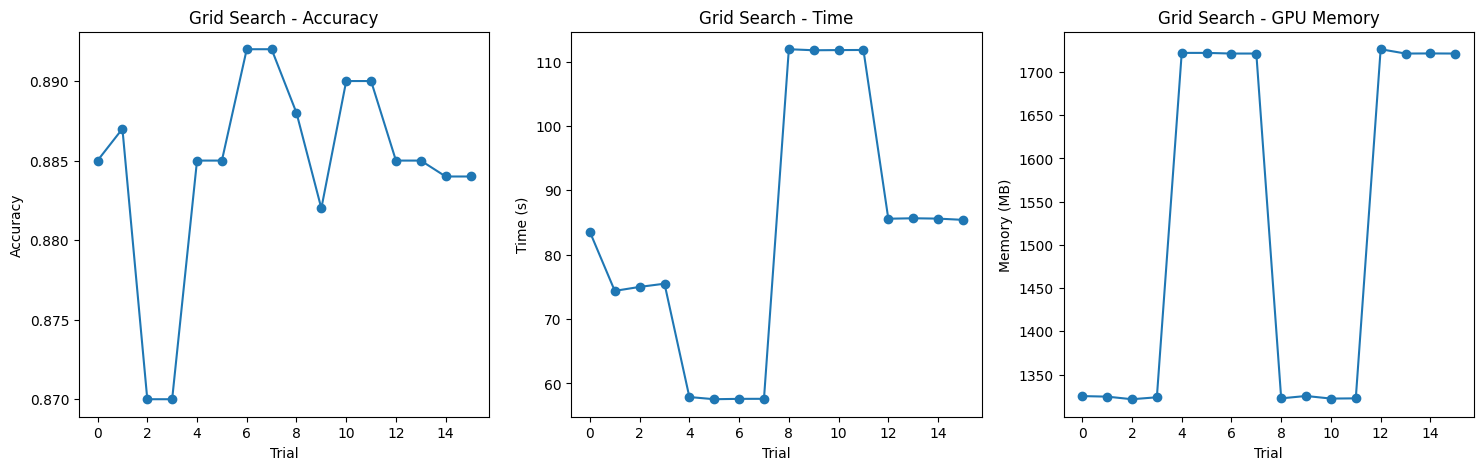

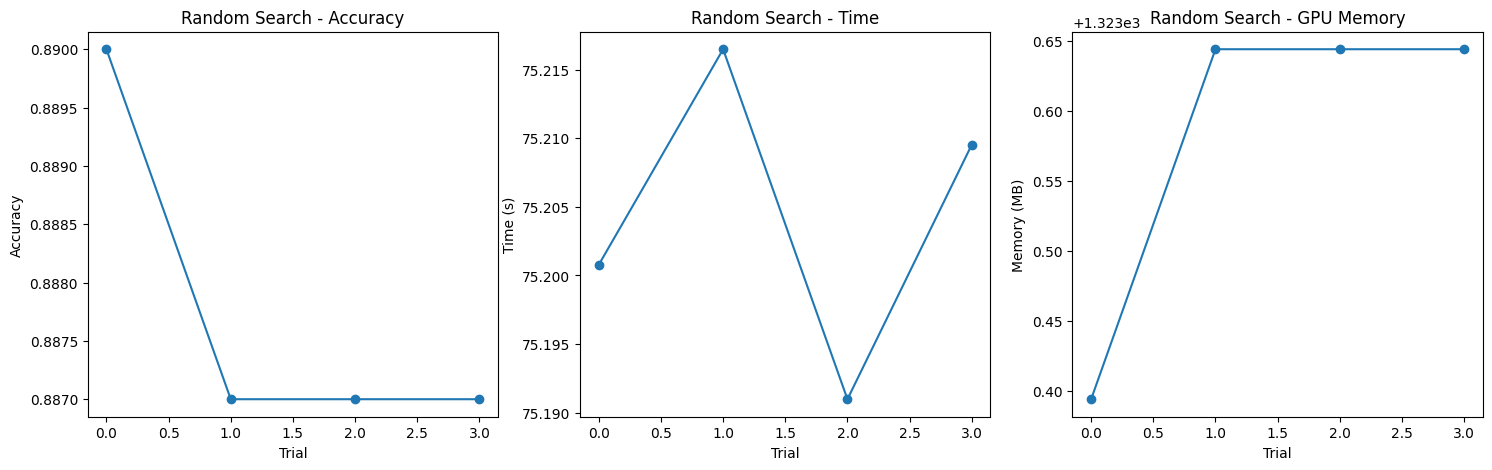

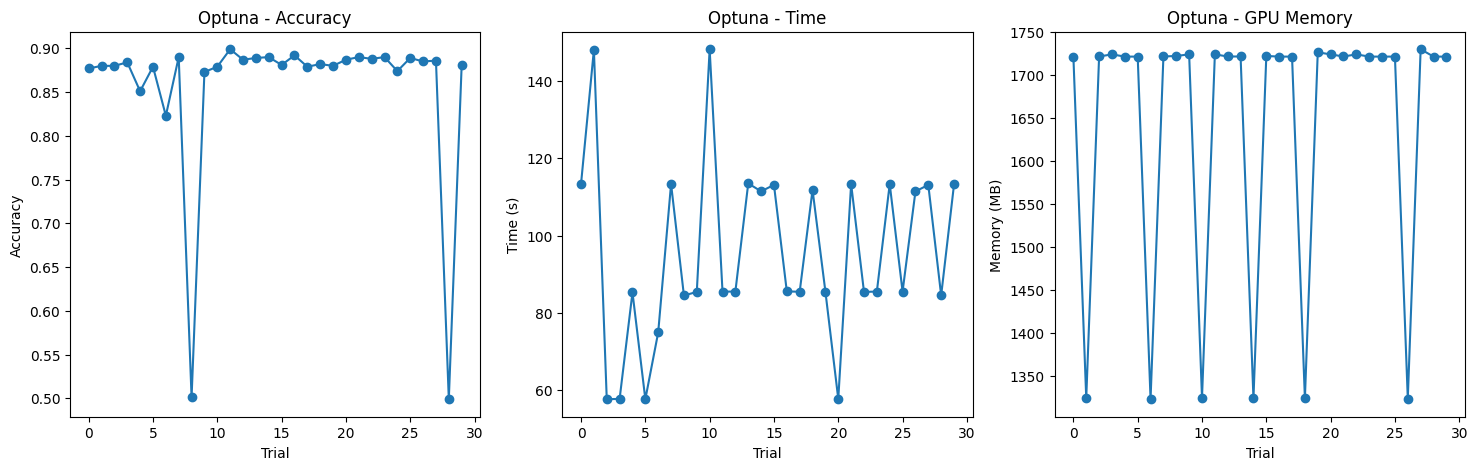

In [ ]:
def plot_results(results, title):
    accs = [r['accuracy'] for r in results]
    times = [r['time'] for r in results]
    mems = [r['memory'] for r in results]

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    axs[0].plot(accs, marker='o'); axs[0].set_title(f"{title} - Accuracy"); axs[0].set_ylabel("Accuracy")
    axs[1].plot(times, marker='o'); axs[1].set_title(f"{title} - Time"); axs[1].set_ylabel("Time (s)")
    axs[2].plot(mems, marker='o'); axs[2].set_title(f"{title} - GPU Memory"); axs[2].set_ylabel("Memory (MB)")
    for ax in axs: ax.set_xlabel("Trial")
    plt.show()

plot_results(grid_results, "Grid Search")
plot_results(random_results, "Random Search")
plot_results(optuna_results, "Optuna")